In [40]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/spaceship-titanic/sample_submission.csv
/kaggle/input/spaceship-titanic/train.csv
/kaggle/input/spaceship-titanic/test.csv


In [41]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

In [42]:
train = pd.read_csv('/kaggle/input/spaceship-titanic/train.csv')
test = pd.read_csv('/kaggle/input/spaceship-titanic/test.csv')
submission = pd.read_csv('/kaggle/input/spaceship-titanic/sample_submission.csv')

In [43]:
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [44]:
train.columns

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name', 'Transported'],
      dtype='object')

In [45]:
train.columns[train.isnull().any()]

Index(['HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age', 'VIP',
       'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Name'],
      dtype='object')

In [46]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [47]:
import seaborn as sns
import matplotlib.pyplot as plt

<Axes: >

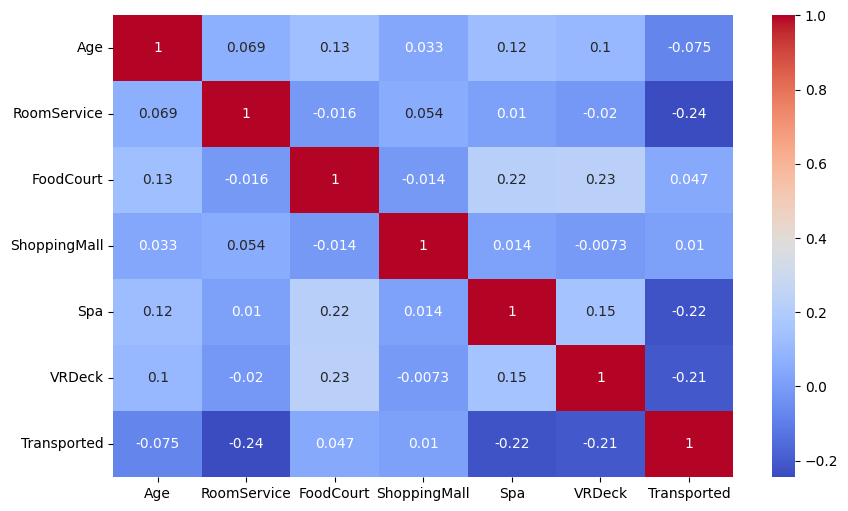

In [48]:
corr = train.corr(numeric_only=True)
plt.figure(figsize=(10, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm')

In [49]:
def preprocess(df):
    # Split Cabin into deck, number, side
    df[['Deck', 'CabinNum', 'Side']] = df['Cabin'].str.split('/', expand=True)
    
    # Fill missing values
    for col in ['HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'VIP', 'Deck', 'Side']:
        df[col] = df[col].fillna(df[col].mode()[0])
    
    df['Age'] = df['Age'].fillna(df['Age'].median())
    
    # Fill NaNs in spending columns with 0
    spend_cols = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
    df[spend_cols] = df[spend_cols].fillna(0)
    
    # Total spending
    df['TotalSpend'] = df[spend_cols].sum(axis=1)
    
    # IsAlone (group size = 1)
    df['Group'] = df['PassengerId'].apply(lambda x: x.split('_')[0])
    group_sizes = df['Group'].map(df['Group'].value_counts())
    df['IsAlone'] = (group_sizes == 1).astype(int)
    
    # Drop unused columns
    df = df.drop(['Name', 'Cabin', 'PassengerId'], axis=1)
    
    # Encode categorical variables
    for col in df.select_dtypes('object').columns:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        
    return df

In [ ]:
y = train['Transported'].astype(int)

train_processed = preprocess(train).drop(columns=['Transported']) 
test_processed = preprocess(test)

In [51]:
X_train, X_val, y_train, y_val = train_test_split(train_processed, y, test_size=0.2, random_state=42)

model = RandomForestClassifier(n_estimators=200, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=200, random_state=42)

In [52]:
val_preds = model.predict(X_val)
print(f"Validation Accuracy: {accuracy_score(y_val, val_preds):.4f}")

Validation Accuracy: 0.7855


In [53]:
test_preds = model.predict(test_processed)

In [54]:
submission['Transported'] = test_preds.astype(bool)
submission.to_csv('/kaggle/working/submission.csv', index=False)
submission.head()

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,False
